In [1]:
import pandas as pd
import numpy as np
import requests
import os
import json
import copy
import multiprocessing as mp
from multiprocessing import Pool
import psutil
from fuzzyset import FuzzySet
from matplotlib import pyplot as plt

from workers import *

In [2]:
# how many ticks on the map color bar
cbarticks = 10
# coefficient for gamma
gexp = 0.2

In [3]:
# get GeoJSON for counties
# https://eric.clst.org/tech/usgeojson/
geofile = 'gz_2010_us_050_00_20m.json'
geourl = 'https://eric.clst.org/assets/wiki/uploads/Stuff/' + geofile
if not os.path.exists(geofile):
    req = requests.get(geourl)
    with open(geofile, 'wb') as f:
        f.write(req.content)

with open(geofile, encoding='ISO-8859-1') as f:
    counties = json.load(f)

# add geo id field compatible with the data format
for c in counties['features']:
    c['id'] = c['properties']['GEO_ID'][-5:]

In [4]:
# get GeoJSON data for states
# https://eric.clst.org/tech/usgeojson/
geostatefile = 'gz_2010_us_040_00_20m.json'
geostateurl = 'https://eric.clst.org/assets/wiki/uploads/Stuff/' + geostatefile
if not os.path.exists(geostatefile):
    req = requests.get(geostateurl)
    with open(geostatefile, 'wb') as f:
        f.write(req.content)

with open(geostatefile) as f:
    jstates = json.load(f)
#jstates

In [5]:
# convert states from Polygon to LineString
states = copy.deepcopy(jstates)
for k, feat in enumerate(jstates['features']):
    if feat['geometry']['type']=='Polygon':
        states['features'][k]['geometry']['type']='LineString'
        states['features'][k]['geometry']['coordinates']=feat['geometry']['coordinates'][0]
    elif  feat['geometry']['type']=='MultiPolygon':
        states['features'][k]['geometry']['type']='MultiLineString' 
        states['features'][k]['geometry']['coordinates']=[linea[0] 
                                                           for linea in feat['geometry']['coordinates']]
    else: 
        raise ValueError('geom-type is not polygon or multipolygon')
#states

In [6]:
# get population data
# this should rarely be updated, if ever
# https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/
popxl = 'PopulationEstimates.xls'
popurl = 'https://www.ers.usda.gov/webdocs/DataFiles/48747/' + popxl
if not os.path.exists(popxl):
    req = requests.get(popurl)
    with open(popxl, 'wb') as f:
        f.write(req.content)

popdf = pd.read_excel(popxl, sheet_name='Population Estimates 2010-19', usecols=[0, 19, 2, 1], header=2)

# first line is the whole country, don't need it
popdf.drop([0], inplace=True)

# merge names into single columns, set FIPS as index
popdf.rename(columns={'FIPStxt': 'FIPS', 'POP_ESTIMATE_2019': 'pop'}, inplace=True)

popdf.set_index('FIPS', inplace=True)
popdf.index.name = None
popdf['name'] = popdf['Area_Name'] + ', ' + popdf['State']
popdf.drop(columns=['State', 'Area_Name'], inplace=True)
popdf

,pop,name
1000,4903185,"Alabama, AL"
1001,55869,"Autauga County, AL"
1003,223234,"Baldwin County, AL"
1005,24686,"Barbour County, AL"
1007,22394,"Bibb County, AL"
...,...,...
72145,50023,"Vega Baja Municipio, Puerto Rico, PR"
72147,8386,"Vieques Municipio, Puerto Rico, PR"
72149,21372,"Villalba Municipio, Puerto Rico, PR"
72151,32282,"Yabucoa Municipio, Puerto Rico, PR"


In [7]:
# get COVID-19 data
# this should be updated daily
# https://github.com/CSSEGISandData/COVID-19
tsfile = 'time_series_covid19_confirmed_US.csv'
tsurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/' + tsfile
if not os.path.exists(tsfile):
    req = requests.get(tsurl)
    with open(tsfile, 'wb') as f:
        f.write(req.content)

t = pd.read_csv(tsfile)

# no FIPS, no play
t = t[t['FIPS'].notna()].copy(deep=True)
t

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,301,303,307,309,310,310,310,312,312,313
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,31,31,31,31,31,33,33,33,36,36
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,8585,8714,8745,8862,9137,9366,9654,10010,10123,10379
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,112,116,122,144,153,167,181,206,206,243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3246,84090053,US,USA,840,90053.0,Unassigned,Washington,US,0.0000,0.0000,...,186,116,137,145,119,119,137,171,143,127
3247,84090054,US,USA,840,90054.0,Unassigned,West Virginia,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
3248,84090055,US,USA,840,90055.0,Unassigned,Wisconsin,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
3249,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
st_pop_file = 'nst-est2019-alldata.csv'
st_pop_url = 'http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/' + st_pop_file
if not os.path.exists(st_pop_file):
    req = requests.get(st_pop_url)
    with open(st_pop_file, 'wb') as f:
        f.write(req.content)

st1 = t[['Province_State'] + list(t.columns[11:])].copy(deep=True)
st2 = st1.groupby(['Province_State']).sum()
not_states = ['Diamond Princess', 'Grand Princess', 'American Samoa', 'Virgin Islands', 'Guam', 'Northern Mariana Islands', 'Puerto Rico']
st2.drop(not_states, inplace=True)

st_pop_init = pd.read_csv(st_pop_file)
st_pop = st_pop_init[['NAME', 'POPESTIMATE2019']].iloc[5:]
st_pop.set_index('NAME', inplace=True)
st_pop

,POPESTIMATE2019
NAME,
Alabama,4903185
Alaska,731545
Arizona,7278717
Arkansas,3017804
California,39512223
Colorado,5758736
Connecticut,3565287
Delaware,973764
District of Columbia,705749


In [34]:
states_abs = st2.transpose()
states_abs.columns.name = None

# smooth the graph
states_abs = states_abs.rolling(21, min_periods=1, center=True, win_type='blackmanharris').mean().copy(deep=True)

# Convert cumulative numbers into daily deltas.
states_abs = states_abs.diff(axis=0).copy(deep=True)
# fill back first row with 0, because diff nuked it into NaN
states_abs.loc['1/22/20'] = 0
# there can be no negative deltas
states_abs.clip(lower=0, inplace=True)

states_abs

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
1/22/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1/23/20,0.000000,0.000000,0.082631,0.000000,0.167360,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1/24/20,0.000000,0.000000,0.099723,0.000000,0.205856,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1/25/20,0.000000,0.000000,0.113280,0.000000,0.242627,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1/26/20,0.000000,0.000000,0.119708,0.000000,0.274808,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7/11/20,1295.227117,45.619352,2750.347783,588.200922,7315.178869,351.290843,61.583196,73.245382,44.822681,9031.291527,...,48.933567,1486.337299,7560.030776,420.562669,6.198054,667.427729,575.787434,106.607248,617.285511,28.136977
7/12/20,1186.995744,42.469470,2372.581713,527.721936,6470.702320,312.256583,53.934833,63.088912,40.173476,8237.111836,...,41.862416,1349.978438,6686.838430,368.394479,5.640011,615.824190,530.693143,92.270472,559.902167,25.497954
7/13/20,1049.121340,37.736499,1991.076751,454.995290,5584.610470,267.295844,46.684113,53.267347,34.807996,7237.733473,...,34.690104,1188.133139,5729.881274,310.769311,4.934445,547.594324,475.064163,77.083199,489.504393,22.479779
7/14/20,902.576685,32.298912,1642.807160,380.781776,4746.227777,223.092736,40.199006,44.314582,29.476378,6172.589422,...,28.223306,1022.520825,4807.385793,254.969573,4.192102,473.305640,414.688686,62.923058,416.458421,19.406825


In [35]:
states_rel = states_abs.copy(deep=True)
for c in states_rel.columns.tolist():
    states_rel[c] = states_rel[c] / st_pop['POPESTIMATE2019'].loc[c]
states_rel

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
1/22/20,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1/23/20,0.000000,0.000000,1.135247e-08,0.000000,4.235661e-09,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1/24/20,0.000000,0.000000,1.370057e-08,0.000000,5.209924e-09,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1/25/20,0.000000,0.000000,1.556324e-08,0.000000,6.140547e-09,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1/26/20,0.000000,0.000000,1.644627e-08,0.000000,6.955012e-09,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7/11/20,0.000264,0.000062,3.778616e-04,0.000195,1.851371e-04,0.000061,0.000017,0.000075,0.000064,0.000420,...,0.000055,0.000218,0.000261,0.000131,0.000010,0.000078,0.000076,0.000059,0.000106,0.000049
7/12/20,0.000242,0.000058,3.259615e-04,0.000175,1.637646e-04,0.000054,0.000015,0.000065,0.000057,0.000384,...,0.000047,0.000198,0.000231,0.000115,0.000009,0.000072,0.000070,0.000051,0.000096,0.000044
7/13/20,0.000214,0.000052,2.735478e-04,0.000151,1.413388e-04,0.000046,0.000013,0.000055,0.000049,0.000337,...,0.000039,0.000174,0.000198,0.000097,0.000008,0.000064,0.000062,0.000043,0.000084,0.000039
7/14/20,0.000184,0.000044,2.257001e-04,0.000126,1.201205e-04,0.000039,0.000011,0.000046,0.000042,0.000287,...,0.000032,0.000150,0.000166,0.000080,0.000007,0.000055,0.000054,0.000035,0.000072,0.000034


In [11]:
# keep only FIPS and dates
ts = t[['FIPS'] + list(t.columns[11:])].copy(deep=True)
# FIPS is integer
ts['FIPS'] = ts['FIPS'].astype(int)
ts

,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20
0,60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,0,0,0,0,0,0,0,0,0,...,301,303,307,309,310,310,310,312,312,313
2,69,0,0,0,0,0,0,0,0,0,...,31,31,31,31,31,33,33,33,36,36
3,72,0,0,0,0,0,0,0,0,0,...,8585,8714,8745,8862,9137,9366,9654,10010,10123,10379
4,78,0,0,0,0,0,0,0,0,0,...,112,116,122,144,153,167,181,206,206,243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3246,90053,0,0,0,0,0,0,0,0,0,...,186,116,137,145,119,119,137,171,143,127
3247,90054,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3248,90055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3249,90056,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# if a FIPS is missing from the data, backfill it from GeoJSON
# or else the map will have holes in it
# extract all known FIPS from GeoJSON
allcodes = [int(c['id']) for c in counties['features']]
len(allcodes)

3221

In [13]:
# now look for missing FIPS codes in data, and backfill them in from GeoJSON
# data will be all 0 for the backfilled rows
for c in allcodes:
    if c not in ts['FIPS'].tolist():
        newrow = {}
        newrow.update({'FIPS': c})
        for col in ts.columns.tolist()[1:]:
            newrow.update({col: 0})
        ts = ts.append(newrow, ignore_index=True)

In [14]:
# GeoJSON is king. We need to have as many FIPS codes from GeoJSON
# as possible in the map, or else there will be missing portions.

# set FIPS as index
ts.set_index('FIPS', inplace=True)
ts

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20
FIPS,,,,,,,,,,,,,,,,,,,,,
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,0,0,0,0,...,301,303,307,309,310,310,310,312,312,313
69,0,0,0,0,0,0,0,0,0,0,...,31,31,31,31,31,33,33,33,36,36
72,0,0,0,0,0,0,0,0,0,0,...,8585,8714,8745,8862,9137,9366,9654,10010,10123,10379
78,0,0,0,0,0,0,0,0,0,0,...,112,116,122,144,153,167,181,206,206,243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# transpose: dates are index, FIPS are columns
df = ts.transpose(copy=True)
# clean the dates header
df.columns.name = None
df

,60,66,69,72,78,1001,1003,1005,1007,1009,...,72107,72113,72121,72127,72133,72141,72071,72003,72009,72015
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7/11/20,0,310,33,9366,167,676,1207,394,221,296,...,0,0,0,0,0,0,0,0,0,0
7/12/20,0,310,33,9654,181,698,1277,399,224,320,...,0,0,0,0,0,0,0,0,0,0
7/13/20,0,312,33,10010,206,715,1341,402,227,331,...,0,0,0,0,0,0,0,0,0,0
7/14/20,0,312,36,10123,206,733,1396,413,232,344,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# smooth the graph
df = df.rolling(21, min_periods=1, center=True, win_type='blackmanharris').mean().copy(deep=True)

# Original data has cumulative numbers - columns increment forever.
# Convert cumulative numbers into daily deltas.
df = df.diff(axis=0).copy(deep=True)
# fill back first row with 0, because diff nuked it into NaN
df.loc['1/22/20'] = 0
# there can be no negative deltas
df.clip(lower=0, inplace=True)

# what is the most recent day in the data?
#lday = df.index.tolist()[-1].split('/')
#last_day = '20' + lday[2] + '/' + lday[0].rjust(2, '0') + '/' + lday[1].rjust(2, '0')
last_day = lfill_date(df.index.tolist()[-1])

In [17]:
# This is where we start processing absolute numbers (total count, simple count)

usabs = df.copy(deep=True)
# the *lin data has the values before gamma
usabslin = usabs.copy(deep=True)
# generate color bar ticks from linear data
usabsticks = makebarticks(usabslin, gexp, cbarticks)

# apply gamma to make everyone visible
usabs = usabs.apply(gamma, g=gexp, max=np.unique(usabs).tolist()[-1]).copy(deep=True)

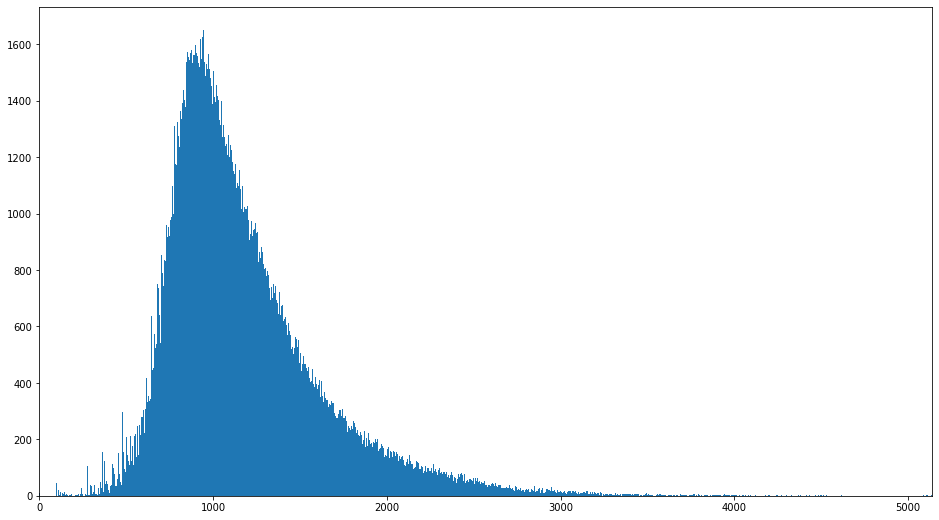

In [18]:
# distribution of values
plt.figure(figsize=(16, 9))
histvals = np.unique(usabs).tolist()
plt.xlim([0, histvals[-1]])
_ = plt.hist(histvals, bins=1000)

In [19]:
# This is where we start processing relative numbers (per capita)

usrel = df.copy(deep=True)

# divide by population
for c in usrel.columns:
    if c in popdf.index.tolist():
        usrel[c] = usrel[c] / popdf.loc[c, 'pop']
    else:
        # could not find population for that FIPS, so set numbers to 0
        usrel[c] = 0
usrellin = usrel.copy(deep=True)
# generate color bar ticks from linear data
usrelticks = makebarticks(usrellin, gexp, cbarticks)

# apply gamma to make everyone visible
usrel = usrel.apply(gamma, g=gexp, max=np.unique(usrel).tolist()[-1]).copy(deep=True)

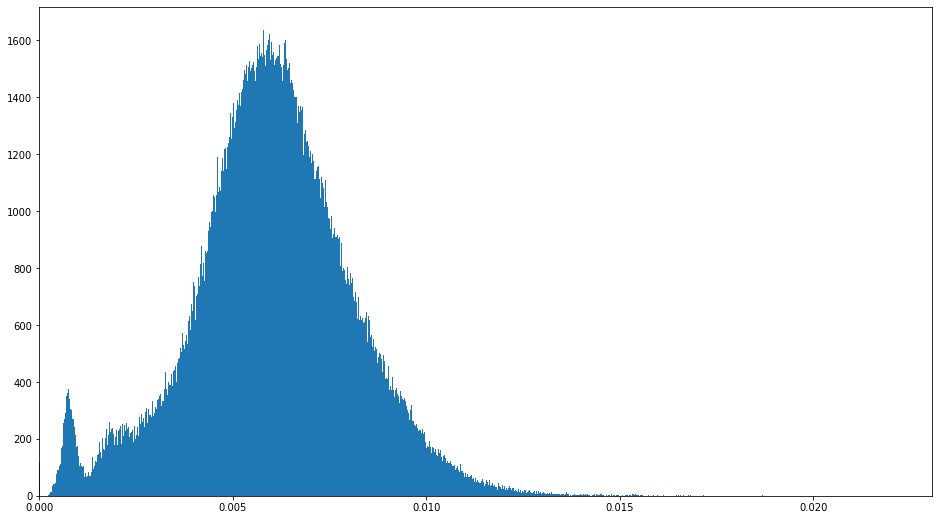

In [20]:
# distribution of values
plt.figure(figsize=(16, 9))
histvals = np.unique(usrel).tolist()
plt.xlim([0, histvals[-1]])
_ = plt.hist(np.unique(usrel).tolist(), bins=1000)

In [21]:
dfcopy = usabs.copy(deep=True)
colint = dfcopy.columns.tolist()
colstr = [str(_).rjust(5, '0') for _ in colint]
dfcopy.rename(columns=dict(zip(colint, colstr)), inplace=True)
dfcopy

,00060,00066,00069,00072,00078,01001,01003,01005,01007,01009,...,72107,72113,72121,72127,72133,72141,72071,72003,72009,72015
1/22/20,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/23/20,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/24/20,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/25/20,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/26/20,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7/11/20,0.0,984.495841,815.648281,2733.524344,1568.299950,1568.052802,2103.339891,1428.646024,1308.948457,1565.320857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7/12/20,0.0,900.356266,854.574189,2765.014698,1579.639247,1586.763761,2089.168025,1424.968581,1280.578710,1581.824663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7/13/20,0.0,850.351407,867.690617,2733.389980,1564.958325,1576.482211,2060.322819,1392.098408,1233.443200,1566.444822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7/14/20,0.0,816.423931,858.023645,2634.683430,1524.652495,1528.526874,2006.460704,1339.377939,1177.079381,1518.767001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# multiprocessing

def make_wargs(df, ticktuple, workers, map, data_type, scale, states, map_folder, gexp):
    # each worker needs data to work on
    # let's generate arguments for each worker
    
    # geo data has FIPS codes as strings, left-padded with 0
    # let's convert our columns to that
    colint = df.columns.tolist()
    colstr = [str(_).rjust(5, '0') for _ in colint]
    df.rename(columns=dict(zip(colint, colstr)), inplace=True)
    
    # distribute the list of dates equally among all workers (round-robin)
    wdlist = [[] for _ in range(workers)]
    for ind, val in enumerate(df.index.tolist()):
        wdlist[ind % workers].append(val)
    
    # build argument tuples for workers
    # (lat, lon, zoom, w, h)
    map_geom = (38.5, -96.1, 4.4, 1920, 1080)
    # (title_x, title_y, title_font_size)
    title_geom = (0.03, 0.97, 32)
    warglist = [(df.loc[wdlist[w]], counties, 'id', map_scope, 'counties', map_geom, data_type, title_geom, map_folder, gexp, ticktuple, states) for w in range(workers)]
    # each tuple in the list is the argument for one worker
    return(warglist)

In [23]:
map_scope = 'USA'

In [23]:
# With iPython and/or Windows you have to put the worker control in __main__
# and the worker function in a separate module. Fails otherwise.
# Linux / plain Python don't have this issue.
if __name__ == '__main__':
    # one worker per CPU
    workers = psutil.cpu_count(logical = False)
    # MP voodoo. spawn seems to work on Mac and Win.
    # Other methods fail in bizarre ways.
    mp.set_start_method('spawn')

    # Batch processing. We have several tasks:
    # - process absolute numbers
    # - process per capita numbers
    # Make a list and add all tasks to it. Each element is a task.
    # Each element contains all arguments for all workers for that task.
    food4workers = []
    data_type = 'plain numbers'
    food4workers.append(make_wargs(usabs, usabsticks, workers, map_scope, data_type, gexp, states, make_folder_name('map', map_scope, data_type), gexp))
    data_type = 'per capita'
    food4workers.append(make_wargs(usrel, usrelticks, workers, map_scope, data_type, gexp, states, make_folder_name('map', map_scope, data_type), gexp))
    
    # Run all tasks sequentially.
    for f in food4workers:
        # sd is the task name basically
        sd = f[0][8]
        if not os.path.exists(sd):
            os.makedirs(sd)
        # Start the pool, then break it down after each task.
        # Probably safer this way.
        p = Pool(processes = workers)
        work_out = p.map(make_map, f)
        p.close()

In [24]:
bacs = [6041,
       6097,
       6055,
       6095,
       6013,
       6001,
       6085,
       6081,
       6075,
       6087,
       6067,
       6053]

barel = usrellin[bacs].copy(deep=True)

data_type = 'per capita'
plot_scope = 'bay area'
color_ba_rel = assign_colors(barel)
plot_folder = make_folder_name('plot', plot_scope, data_type)
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
make_plots(barel, plot_folder, 'counties', color_ba_rel, data_type, plot_scope, popdf, False)

In [25]:
color_abs = assign_colors(usabslin)
color_rel = assign_colors(usrellin)
plot_scope = map_scope

In [26]:
data_type = 'plain numbers'
plot_folder = make_folder_name('plot', plot_scope, data_type)
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
make_plots(usabslin, plot_folder, 'counties', color_abs, data_type, plot_scope, popdf, True)

data_type = 'per capita'
plot_folder = make_folder_name('plot', plot_scope, data_type)
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
make_plots(usrellin, plot_folder, 'counties', color_rel, data_type, plot_scope, popdf, True)

In [36]:
color_state_abs = assign_colors(states_abs)
plot_scope = 'usa states'
data_type = 'plain numbers'
plot_folder = make_folder_name('plot', plot_scope, data_type)
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
make_plots(states_abs, plot_folder, 'states', color_state_abs, data_type, plot_scope, False, False)

In [37]:
color_state_rel = assign_colors(states_rel)
plot_scope = 'usa states'
data_type = 'per capita'
plot_folder = make_folder_name('plot', plot_scope, data_type)
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
make_plots(states_rel, plot_folder, 'states', color_state_rel, data_type, plot_scope, False, False)

In [28]:
# if all went well, write the most recent timestamp in the data to a file
with open('last-day-usa.txt', 'w') as f:
    f.write(last_day)